In [192]:
import os
import sklearn
import numpy as np
from numpy import unwrap, diff, abs, angle
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from scipy.signal import hilbert
from sklearn.utils import shuffle

import scipy
from scipy.signal import butter, filtfilt, hilbert
from scipy.interpolate import interp1d
from scipy.interpolate import CubicSpline

from tensorflow.keras.models import Sequential
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.layers import Dense,  BatchNormalization, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

import mne
from mne.preprocessing import ICA



Preproccesing Functions

In [193]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def denoise_data(df, col_names, n_clusters):
    df_denoised = df.copy()
    for col_name, k in zip(col_names, n_clusters):
        df_denoised[col_name] = pd.to_numeric(df_denoised[col_name], errors='coerce') # Convert column to numeric format
        X = df_denoised.select_dtypes(include=['float64', 'int64']) # Select only numeric columns
        clf = KNeighborsRegressor(n_neighbors=k, weights='uniform') # Fit KNeighborsRegressor
        clf.fit(X.index.values[:, np.newaxis], X[col_name])
        y_pred = clf.predict(X.index.values[:, np.newaxis]) # Predict values 
        df_denoised[col_name] = y_pred
    return df_denoised

def z_score(df, col_names):
    df_standard = df.copy()
    for col in col_names:
        df_standard[col] = (df[col] - df[col].mean()) / df[col].std()
    return df_standard

def custom_detrend(df, col_names):
    df_detrended = df.copy()
    for col in col_names:
        y = df_detrended[col]
        x = np.arange(len(y))
        p = np.polyfit(x, y, 1)
        trend = np.polyval(p, x)
        detrended = y - trend
        df_detrended[col] = detrended
    return df_detrended

def preprocess(df, col_names, n_clusters):
    df_new = df.copy()
    df_new = denoise_data(df, col_names, n_clusters)
    df_new = z_score(df_new, col_names)
    df_new = custom_detrend(df_new, col_names)
    return df_new

def df_to_raw(df, sfreq=256):
    info = mne.create_info(ch_names=list(df.columns), sfreq=sfreq, ch_types=['eeg'] * df.shape[1])
    raw = mne.io.RawArray(df.T.values * 1e-6, info)  # Converting values to Volts from microvolts for MNE
    return raw

def reject_artifacts(df, channel):
    threshold_factor =3
    median = df[channel].median()
    mad = np.median(np.abs(df[channel] - median))
    spikes = np.abs(df[channel] - median) > threshold_factor * mad
    x = np.arange(len(df[channel]))
    cs = CubicSpline(x[~spikes], df[channel][~spikes])    # Interpolate using Cubic Spline
    interpolated_values = cs(x)
    interpolated_values[spikes] *= 0.1  # Make interpolated values 0.001 times smaller
    df[channel] = interpolated_values
    return df


def reject_artifacts_DN(df, channel):
    threshold_factor =5
    median = df[channel].median()
    mad = np.median(np.abs(df[channel] - median))
    spikes = np.abs(df[channel] - median) > threshold_factor * mad
    x = np.arange(len(df[channel]))
    cs = CubicSpline(x[~spikes], df[channel][~spikes])    # Interpolate using Cubic Spline
    interpolated_values = cs(x)
    interpolated_values[spikes] *= 0.5  # Make interpolated values 0.001 times smaller
    df[channel] = interpolated_values
    return df

Define the dataset

In [ ]:
folder_name = 'a'
selected_columns = ['Fz', 'FC1', 'FC2', 'C3', 'Cz', 'C4', 'CPz', 'Pz','a','b','c','d','e','f','g','h']
duration = 40 
raw=[]
event=[]
BP=[]
PP=[]
if os.path.exists(folder_name) and os.path.isdir(folder_name):
    for file_name in os.listdir(folder_name):
        if file_name.endswith('.csv'):
            file_path = os.path.join(folder_name, file_name)
            s_temp = pd.read_csv(file_path, header=None)
            inst = s_temp.iloc[1536:, 18]
            df_temp = s_temp.iloc[1536:, :16]
            print('df_temp ',df_temp.shape)
            df_temp.columns = selected_columns  # Naming the columns
            raw.append(df_temp)
            event.append(inst)
            raw_mne = df_to_raw(df_temp)
            # raw_mne.plot(n_channels=8, title='Raw Data', scalings=1e-4, duration=duration)
            # 1. Band Pass
            raw_mne_BP=raw_mne.filter(.4, 40)
            # raw_mne_BP.plot(n_channels=8, title='Band Passed Data', scalings=1e-4, duration=duration)
            # 2. Artifact rejection
            BP_artifact_RJ = raw_mne_BP.copy()
            for channel in selected_columns:
                BP_artifact_RJ._data[selected_columns.index(channel), :] = reject_artifacts(pd.DataFrame(raw_mne._data.T, columns=selected_columns), channel)[channel].values
            # BP_artifact_RJ.plot(n_channels=8, title='Artifact Rejected Data', scalings=0.5e-4, duration=duration)
            # 3. Smoothing
            BP_artifact_RJ_SM=BP_artifact_RJ.copy()
            window_size = 10 
            for channel in selected_columns:
                channel_data = pd.Series(BP_artifact_RJ_SM._data[selected_columns.index(channel), :])
                BP_artifact_RJ_SM._data[selected_columns.index(channel), :] = channel_data.rolling(window=window_size, center=True).mean().fillna(method='bfill').fillna(method='ffill').values
            # BP_artifact_RJ_SM.plot(n_channels=8, title='Smoothed Data', scalings=0.5e-4, duration=duration)
            BP.append(BP_artifact_RJ_SM)
            # 4. Denoising and other preprocessing
            eeg_df_denoised = preprocess(pd.DataFrame(BP_artifact_RJ_SM.get_data().T, columns=selected_columns), col_names=selected_columns, n_clusters=[50]*len(selected_columns))
            # eeg_df_denoised.plot(subplots=True, figsize=(15, 10), title='Denoised EEG Data')
            # plt.show()
            # 5. Artifact rejection on denoised data
            eeg_df_denoised_artifact_RJ = eeg_df_denoised.copy()
            for channel in selected_columns:
                eeg_df_denoised_artifact_RJ[channel] = reject_artifacts_DN(eeg_df_denoised, channel)[channel]
            # Plot the artifact-rejected denoised data
            # eeg_df_denoised_artifact_RJ.plot(subplots=True, figsize=(15, 10), title='Artifact-Rejected Denoised EEG Data')
            # plt.show()       
            
            # 6. Smoothing the artifact-rejected denoised data
            window_size = 10  # Adjust this value based on your requirements
            DN_SM = eeg_df_denoised_artifact_RJ.copy()
            for channel in selected_columns:
                channel_data = DN_SM[channel]
                DN_SM[channel] = channel_data.rolling(window=window_size, center=True).mean().fillna(method='bfill').fillna(method='ffill')
            # Plot the smoothed data
            # DN_SM.plot(subplots=True, figsize=(15, 10), title='Smoothed EEG Data')
            # plt.show()
            # PP.append(DN_SM)
            PP.append(eeg_df_denoised_artifact_RJ)

In [210]:
PP_NP=np.array(PP)
event=np.array(event).reshape(40*(df_temp.shape[0]), 1)
raw=np.array(raw).reshape(40*(df_temp.shape[0]), 16)   
denoised=np.array(PP_NP).reshape(40*(df_temp.shape[0]), 16)   
pp_sig_event=np.concatenate((denoised, event), axis=1)

event (348160, 1) raw (348160, 16) denoised (348160, 16) pp_sig_event (348160, 17) face (174080, 17) scene (174080, 17) labels (348160,)
(20, 64, 16)
(64, 16)
(20, 64, 16)
(64, 16) <class 'numpy.ndarray'>


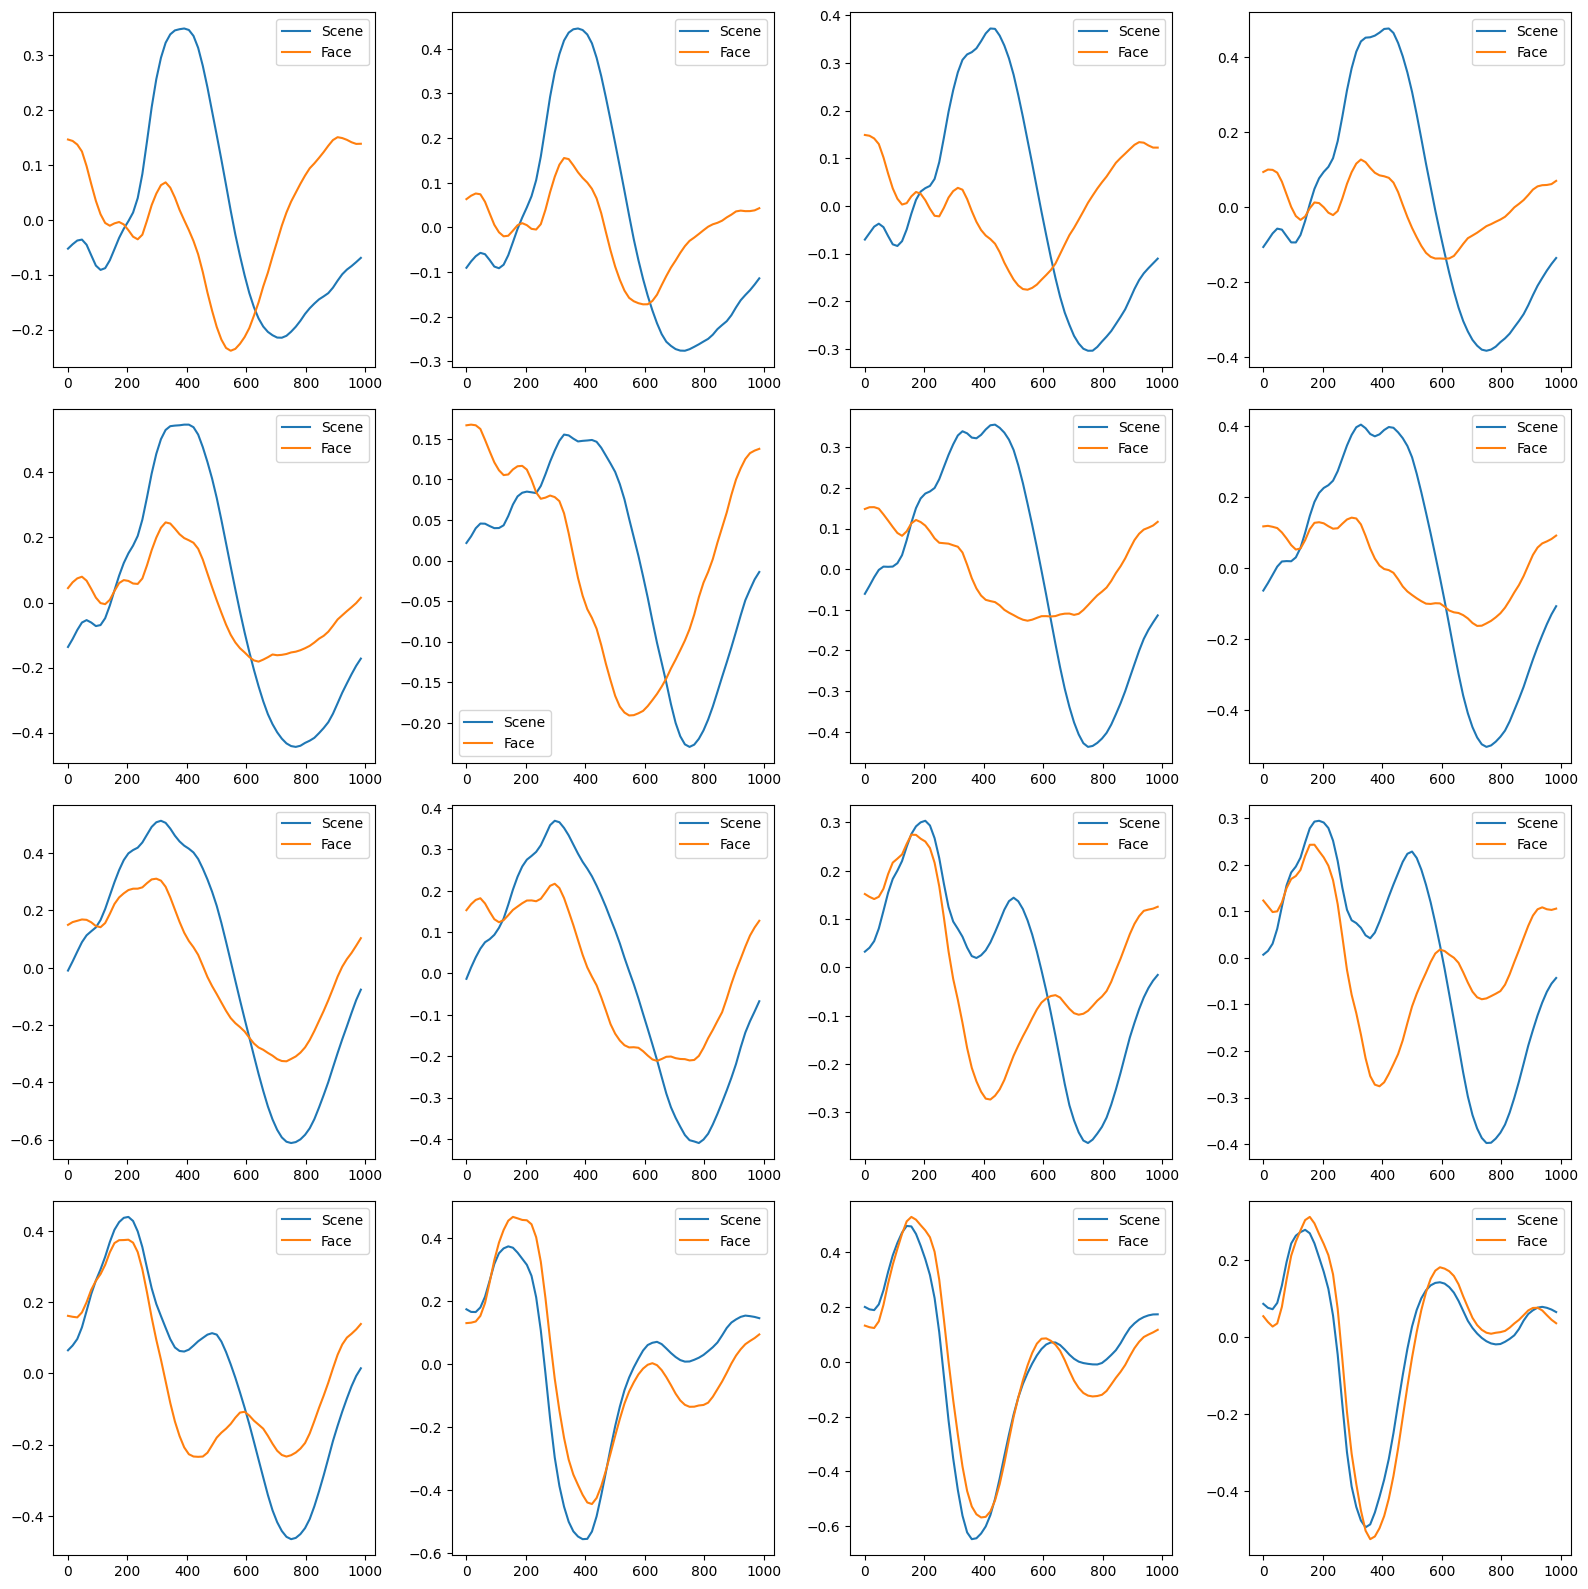

In [211]:
labels=[] 
face = [] #lable=0
scene=[]#lable=1
for i in range(len(pp_sig_event)):
    if 'M' in pp_sig_event[i, 16] or 'F' in pp_sig_event[i, 16]:
        face.append(pp_sig_event[i])
        labels.append(0)
    else:
        scene.append(pp_sig_event[i]) 
        labels.append(1)        
face = np.array(face)
scene = np.array(scene)
labels=np.array(labels)                  
print('event', event.shape, 'raw', raw.shape, 'denoised',  denoised.shape, 'pp_sig_event', pp_sig_event.shape, 'face', face.shape, 'scene', scene.shape, 'labels', labels.shape)     

fs=256

face_eeg_dada=face.reshape(20,int(df_temp.shape[0]/fs),64,4,17)
face_eeg_dada=face_eeg_dada[:,:,:,:,:16]
face_eeg_dada=face_eeg_dada.mean(axis=3)
face_eeg_dada=face_eeg_dada.mean(axis=1)
print(face_eeg_dada.shape)
face_mean=face_eeg_dada.mean(axis=0)
print(face_mean.shape)
scene_eeg_dada=scene.reshape(20,int(df_temp.shape[0]/fs),64,4,17)
scene_eeg_dada=scene_eeg_dada[:,:,:,:,:16]
scene_eeg_dada=scene_eeg_dada.mean(axis=3)
scene_eeg_dada=scene_eeg_dada.mean(axis=1)
print(scene_eeg_dada.shape)
scene_mean=scene_eeg_dada.mean(axis=0)
print(scene_mean.shape, type(scene_mean))
fs=256


time_list=[]
for n in range(face_mean.shape[0]):
    time = (n*4)/(fs)*1000
    time_list.append(time)
plt.figure(figsize=(16,16))
for channel in range(16):
    plt.subplot(4,4, channel + 1)  
    plt.plot(time_list, face_mean[:, channel], label=f'Scene')
    plt.plot(time_list, scene_mean[:, channel], label=f'Face')
    plt.legend()
plt.tight_layout()
plt.show()     

ERP Feature Extraction

In [212]:
c=1000/64
window_50 = (int(50/c),int(150/c))
window_70 = (int(250/c),int(450/c)) 
window_200 = (int(650/c),int(750/c))
# window_350 = (int(850/c),int(950/c))

def extract_ERP_features(epoch):
    region_50= epoch[window_50[0]:window_50[1]]
    region_70= epoch[window_70[0]:window_70[1]]
    region_200= epoch[window_200[0]:window_200[1]]
    # region_350= epoch[window_350[0]:window_350[1]]
    mean_amplitude_50 = np.mean(region_50)
    mean_amplitude_70 = np.mean(region_70)
    mean_amplitude_200 = np.mean(region_200)
    # mean_amplitude_350 = np.mean(region_350)
    
    return [mean_amplitude_50, mean_amplitude_70, mean_amplitude_200]

frequency_bands = {
    'delta': (0.5, 4),
    'theta': (4, 8),
    'alpha': (8, 14),
    'beta': (14, 30),
    'gamma': (30, 40),
    'ERP':(0.4,40)}

def apply_bandpass_filter(signal, lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

def calculate_hilbert_features(signal, fs):
    analytic_signal = hilbert(signal)
    amplitude_envelope = np.abs(analytic_signal)
    instantaneous_phase = angle(analytic_signal)
    unwrapped_phase = unwrap(instantaneous_phase)
    instantaneous_frequency = diff(unwrapped_phase) / (2.0*np.pi) * fs 
    return amplitude_envelope, instantaneous_phase, instantaneous_frequency

def extract_hilbert_features(dataset, fs):
    n_channels = 16
    sampling_rate = 256
    all_hilbert_features = []
    for sample in dataset:
        channel_features = []
        for ch in range(n_channels):
            signal = sample[ch * sampling_rate: (ch + 1) * sampling_rate]
            amplitude_envelope, instantaneous_phase, instantaneous_frequency = calculate_hilbert_features(signal, fs)
            channel_features.append([
                np.mean(amplitude_envelope),
                # np.mean(instantaneous_phase),
                # np.mean(instantaneous_frequency)
            ])
        all_hilbert_features.append(channel_features)
    return np.array(all_hilbert_features)

Feature Extraction

In [213]:
fs=256
X=denoised.reshape(int(denoised.shape[0]/fs), fs*16)
labels=labels.reshape(int(labels.shape[0]/fs), fs)
Y=np.squeeze(labels[:,0])
data = X

In [214]:
hilbert_Fe=[]
for band, (low, high) in frequency_bands.items():
    filtered_signal = apply_bandpass_filter(data, low, high, fs)
    hilbert_bp=extract_hilbert_features(filtered_signal,fs)
    hilbert_Fe.append(hilbert_bp) 

hilbert_Fe_NP=np.array(hilbert_Fe)
print(hilbert_Fe_NP.shape)
hilbert_Fe_NP_transposed = hilbert_Fe_NP.transpose(1, 0, 2, 3)
print(hilbert_Fe_NP_transposed.shape)
a=hilbert_Fe_NP_transposed.reshape(int(denoised.shape[0]/fs), 16, -1)
print(a.shape)

hilbert_Fe_NP_transposed = hilbert_Fe_NP.transpose(1, 0, 2, 3)  # shape becomes (1600, 5, 8, 3)
Hilbert_FE= hilbert_Fe_NP_transposed.reshape(int(denoised.shape[0]/fs), 16, -1)
print(Hilbert_FE.shape)

(6, 1360, 16, 1)
(1360, 6, 16, 1)
(1360, 16, 6)
(1360, 16, 6)


In [215]:
BP_Power_FE = []
for i in range(data.shape[0]):
    eeg_signal = data[i, :].reshape(16, 256)  # reshaped to (8, 250)
    features_for_sample = []
    for channel in range(16):
        channel_signal = eeg_signal[channel, :]
        features_for_channel = []
        hilbert_for_channel=[]
        for band, (low, high) in frequency_bands.items():
            filtered_signal = apply_bandpass_filter(channel_signal, low, high, fs)
            mean_amplitude = np.mean((filtered_signal)**2)
            features_for_channel.append(mean_amplitude)
        features_for_sample.append(features_for_channel) 
    BP_Power_FE.append(features_for_sample)
BP_Power_FE_np = np.array(BP_Power_FE)
print(BP_Power_FE_np.shape) 

data_reshaped = X.reshape(int(denoised.shape[0]/fs), 16, 256)
ERP_FE = np.array([[extract_ERP_features(data_reshaped[i, j, :]) for j in range(5)] for i in range(int(denoised.shape[0]/fs))])
print(ERP_FE.shape)


(1360, 16, 6)
(1360, 5, 3)


In [216]:

f_1=BP_Power_FE_np.reshape(int(BP_Power_FE_np.shape[0]), int(BP_Power_FE_np.shape[1])*int(BP_Power_FE_np.shape[2]))
f_2=ERP_FE.reshape(int(ERP_FE.shape[0]), int(ERP_FE.shape[1])*int(ERP_FE.shape[2]))
# print(f_2.shape)
combined_features = np.concatenate([f_1,f_2], axis=1)
print(combined_features.shape)  # Should print (1600, 8, 11)

(1360, 111)


In [217]:
# all_features=all_features.reshape(1600, 8, 5)
# x=X.reshape(1600, 8, 250)
# sec_feature = np.concatenate([combined_features,x], axis=2)
# print(sec_feature.shape)
# af=sec_feature.reshape(1600, 8*267)
# af=combined_features.reshape(544, 16*combined_features.shape[2])
af=combined_features

In [218]:
af, Y = shuffle(af, Y)
print(af.shape, Y.shape)

# Balance the dataset
oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(af, Y)
X_resampled= X_resampled.astype(np.float32)
y_resampled = y_resampled.astype(np.int32)

# Split X and y into training and testing sets
X_touched, X_untouch, y_touch, y_untouch = train_test_split(X_resampled, y_resampled, test_size=0.1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_touched, y_touch, test_size=0.1, random_state=42)

# Convert y_train and y_test to categorical format for Keras
y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=2)
y_untouch=tf.keras.utils.to_categorical(y_untouch, num_classes=2)

# Convert the data to a numerical type (float)
X_train = X_train.astype(np.float64)
print(X_train.shape)

# Convert one-hot-encoded labels to integer-encoded labels
y_train = np.argmax(y_train, axis=-1)
y_test = np.argmax(y_test, axis=-1)
y_untouch = np.argmax(y_untouch, axis=-1)
print(y_train.shape, y_test.shape)


print('X_train:', X_train.shape, 'y_train:', y_train.shape, 'X_test:', X_test.shape, 'y_test:',
      y_test.shape, 'X_untouch:', X_untouch.shape, 'y_untouch:', y_untouch.shape )

(1360, 111) (1360,)
(1101, 111)
(1101,) (123,)
X_train: (1101, 111) y_train: (1101,) X_test: (123, 111) y_test: (123,) X_untouch: (136, 111) y_untouch: (136,)


In [219]:
from sklearn import svm
from joblib import dump
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
# Create a linear SVM classifier
clf = svm.SVC(kernel='linear')

# Train the classifier
clf.fit(X_train, y_train)
# Save the model to disk
filename = 'C:/Users/tnlab/OneDrive/Documents/GitHub/Neurofeedback-Based-BCI/SVM for Unicorn Data/my_svm_model2.joblib'
dump(clf, filename)

# Make predictions on the test set
y_pred = clf.predict(X_test)

print('Model accuracy: ', accuracy_score(y_test, y_pred))
report_svm_matrix = classification_report(y_test, y_pred)
print("Classification Report:")
print(report_svm_matrix)
report_svm = classification_report(y_test, y_pred, output_dict=True)

report_df_svm = pd.DataFrame(report_svm).transpose()
report_df_svm.to_excel(f"svm_classification_report_{folder_name}.xlsx", index=True)

Model accuracy:  0.5853658536585366
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.58      0.60        67
           1       0.54      0.59      0.56        56

    accuracy                           0.59       123
   macro avg       0.59      0.59      0.58       123
weighted avg       0.59      0.59      0.59       123



In [220]:
from sklearn import svm
from joblib import dump
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd

# Create a nonlinear SVM classifier with RBF kernel
clf = svm.SVC(kernel='rbf', C=1, gamma='scale')

# Train the classifier
clf.fit(X_train, y_train)

# # Save the model to disk
# filename = 'C:/Users/tnlab/OneDrive/Documents/GitHub/AlphaFold/Neurofeedback-Based-BCI/SVM for Unicorn Data'
# dump(clf, filename)

# Make predictions on the test set
y_pred = clf.predict(X_test)

print('Model accuracy: ', accuracy_score(y_test, y_pred))
report_svm_matrix = classification_report(y_test, y_pred)
print("Classification Report:")
print(report_svm_matrix)
report_svm = classification_report(y_test, y_pred, output_dict=True)

report_df_svm = pd.DataFrame(report_svm).transpose()
report_df_svm.to_excel(f"svm_classification_report_{folder_name}.xlsx", index=True)


Model accuracy:  0.5772357723577236
Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.51      0.57        67
           1       0.53      0.66      0.59        56

    accuracy                           0.58       123
   macro avg       0.59      0.58      0.58       123
weighted avg       0.59      0.58      0.58       123

